In [1]:
%load_ext autoreload
%autoreload 2
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import particle as pt
from anytree import Node, RenderTree
from scipy import stats
from scipy.optimize import curve_fit
import mplhep 
mplhep.style.use(mplhep.style.ROOT)
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('/home/henrique/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/personal/Henrique/')
from ana_tree_class import AnaTreeAnalyzer

# plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'


In [2]:
def get_theta_phi(dcosx, dcosy, dcosz):
    """ Return theta and phi from versors
    I am keeping the geant output of theta[0, pi] and phi[-pi,pi]
    """
    theta = np.arccos(dcosz)
    if dcosx == 0:
        phi = 0
        if dcosy == 0:
            pass
        elif dcosy > 0:
            phi = np.pi/2
        elif dcosy < 0:
            phi = -np.pi/2
        return theta, phi

    phi = np.arctan(dcosy/dcosx)
    if phi == 0:
        if (dcosx > 0):
            return theta, phi
        else:
            return theta, phi+np.pi
    if phi > 0:
        if dcosx > 0:
            return theta, phi
        else:
            return theta, phi-np.pi
    else: 
        if dcosx > 0:
            return theta, phi
        else:
            return theta, np.pi+phi

In [286]:
tree = uproot.open("./anatree_hd_AV_sum.root:analysistree/anatree")

In [287]:
ana = AnaTreeAnalyzer(file="./anatree_hd_AV_sum.root:analysistree/anatree")
ana.loadTree()

In [288]:
ana.data["Length_geant"]
data = ana.data
data_original = ana.data

In [289]:
ana.add_track_geant_info(data)

In [354]:
track_length = 0
newselection = 0
def process_data(particle_pdg = 13):
    global data_original
    global data
    global track_length
    global newselection
    data = data_original
    # data = data[data["ccnc_truth"][:,0] == 0 ]
    # data = data[abs( data["nuPDG_truth"][:,0] ) == 14 ]
    def select_particle(pdg = 13):
        return abs(data["trkg4pdg_pandoraTrack"] == pdg)


    # # Give me the index over geant data for particles matching the pdgcode
    selection = data["trkg4idx_pandoraTrack"][select_particle(particle_pdg)]
    # mask = ana.check_fiducial(data, filter=selection,type="geant")
    # mask = [np.all(m) if len(m) != 0 else False for m in mask]

    # data = data[mask]
    track_length = data["trklen_pandoraTrack"][select_particle(particle_pdg)]
    selection = data["trkg4idx_pandoraTrack"][select_particle(particle_pdg)]
    track_length = track_length.to_list()
    newselection = selection.to_list()
    def Checker(reader):
        return len(np.unique(reader)) != len(reader)

    for i, (sel, lgt) in enumerate(zip(selection, track_length)):
        if len(sel) > 1:
            result_dict = {}
            # if(Checker(sel)):
            # print(f'{track_length[i]} and {sel}')
            for idx, length in zip (sel, lgt):
                
                # Check if the id already exists in the dictionary
                if idx in result_dict:
                    # If yes, accumulate the value
                    result_dict[idx] += length
                else:
                    # If not, initialize the value
                    result_dict[idx] = length
            track_length[i] = list(result_dict.values())
            newselection[i] = list(result_dict.keys())
            # print(f'{track_length[i]} and {newselection[i]}')


In [383]:
def plot_track_range(particle_pdg = 13, tick_distance = 250, max_scale=1.05, max_res = 1, min_track_len = 0, bins2d = 200, bins1d = 400, range=None):
        

    track_length_ = ak.Array(track_length)
    newselection_ = ak.Array(newselection)
    geant_length = data["pathlen_drifted_geant"][newselection_]

    geant_length = ak.flatten(geant_length).to_numpy()
    track_length_ = ak.flatten(track_length_).to_numpy()

    fig, ax = plt.subplots(1,2,figsize=(17,8))

    ax[0].set_autoscale_on(False)
    counts, xedges, yedges, im = ax[0].hist2d(geant_length, track_length_,bins=bins2d,range=range, norm='log');
    particle_name = pt.Particle.from_pdgid(particle_pdg).pdg_name
    ax[0].set_xlabel(f'MC {particle_name} length (cm)')
    ax[0].set_ylabel(f'Reco {particle_name} track length (cm)')
    max_val = np.max([geant_length,track_length_])

    if range==None:
        ax[0].set_xlim(0,max_val*max_scale)
        ax[0].set_ylim(0,max_val*max_scale)
        ax[0].set_xticks(np.arange(0,max_val*max_scale//100*100+1, tick_distance))
        ax[0].set_yticks(np.arange(0,max_val*max_scale//100*100+1, tick_distance))
    else:
        ax[0].set_xticks(np.arange(0,range[0][1]+1, tick_distance))
        ax[0].set_yticks(np.arange(0,range[1][1]+1, tick_distance))

    fig.colorbar(im, ax=ax[0], location='right', aspect=30, pad=0.01)

    track_distance_res = [(t-g)/g for t,g in zip(track_length_,geant_length) if g > min_track_len]
    track_distance_res = np.array(track_distance_res)
    ax[1].hist(track_distance_res, bins=bins1d, range=[-1,max_res]);
    ax[1].set_xlabel(r'$\frac{Reco-MC}{MC}$')
    ax[1].set_ylabel('# of events')
    textstat = '\n'.join((
        r'$\mu=%.4f$' % (np.mean(track_distance_res)),
        r'$\mu_{1/2}=%.4f$' % (np.median(track_distance_res)),
        r'$\sigma=%.4f$' % (np.std(track_distance_res))))
    ax[1].text(0.7, 0.81, textstat, transform=ax[1].transAxes,
        bbox=dict(facecolor='white', edgecolor='black'),size=16)
    
    figname = f'{particle_name}_track_length_res.png'
    fig.tight_layout()
    fig.savefig(f'graphs/{figname}')



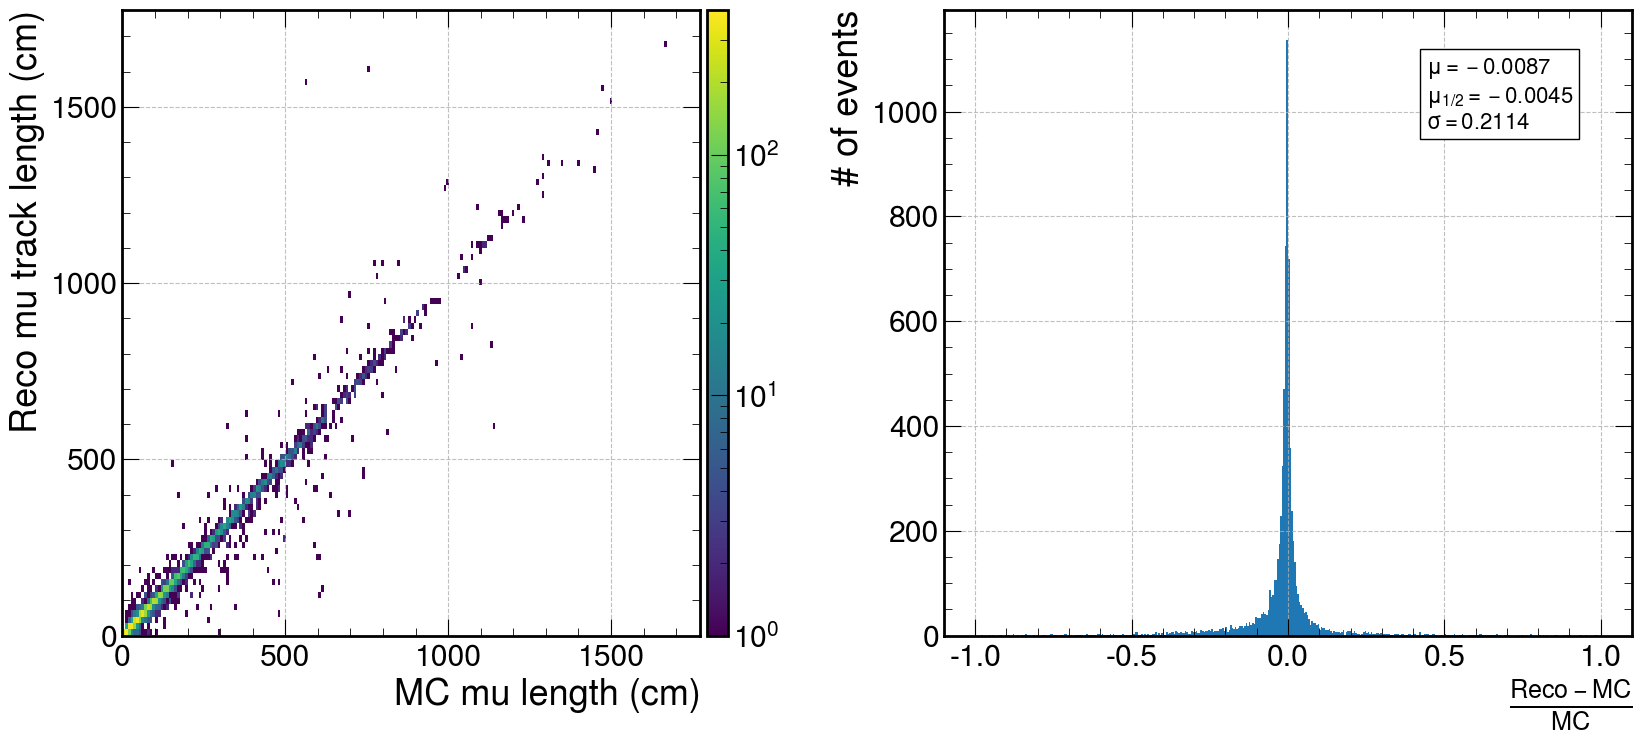

In [363]:
process_data(13)
plot_track_range(13,min_track_len=0,max_scale=0.5, tick_distance=500)

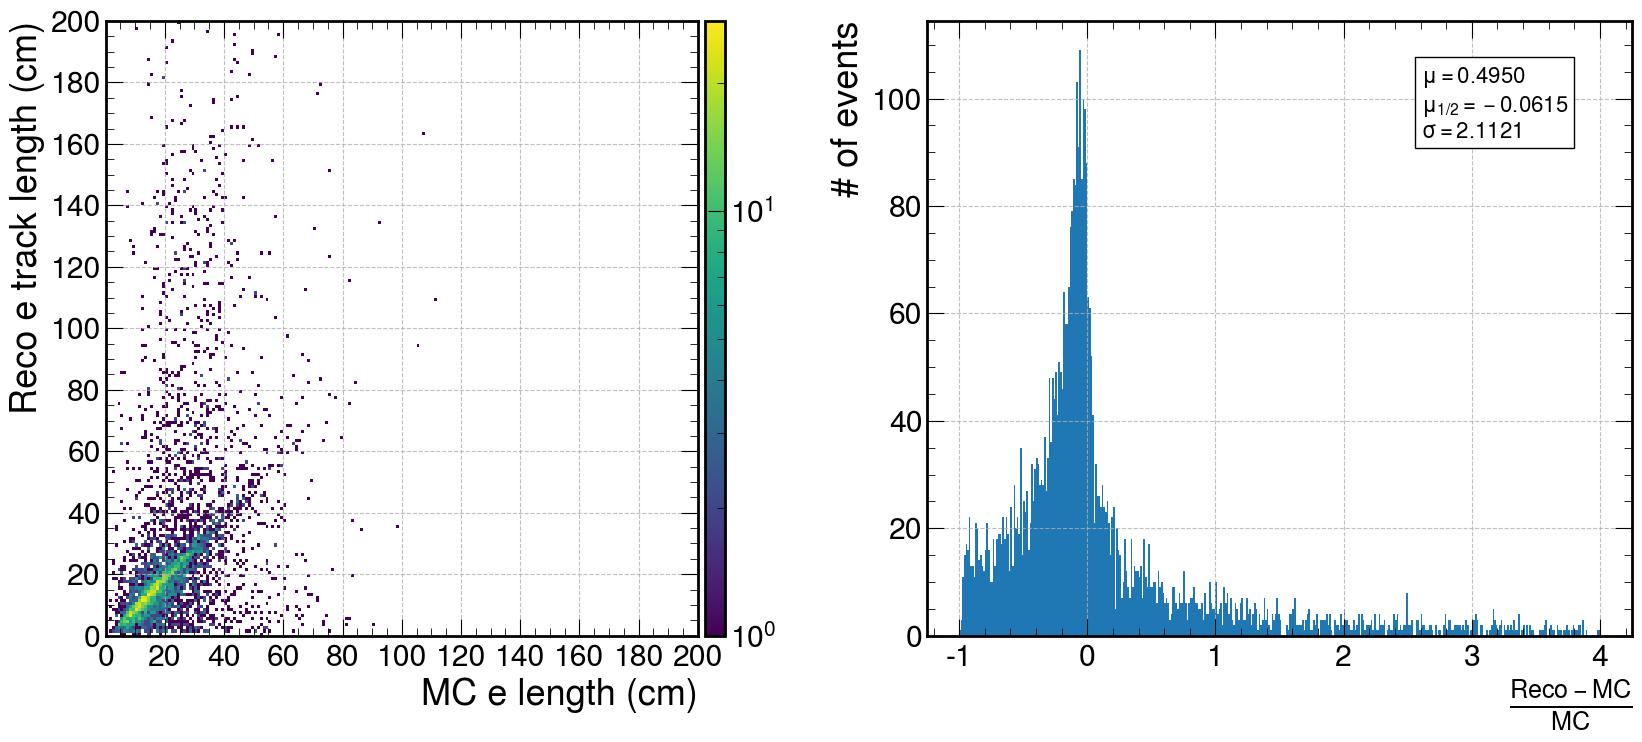

In [385]:
process_data(11)
plot_track_range(11,tick_distance=20,bins2d=[200,200], range=[[0,200],[0,200]],max_res=4)

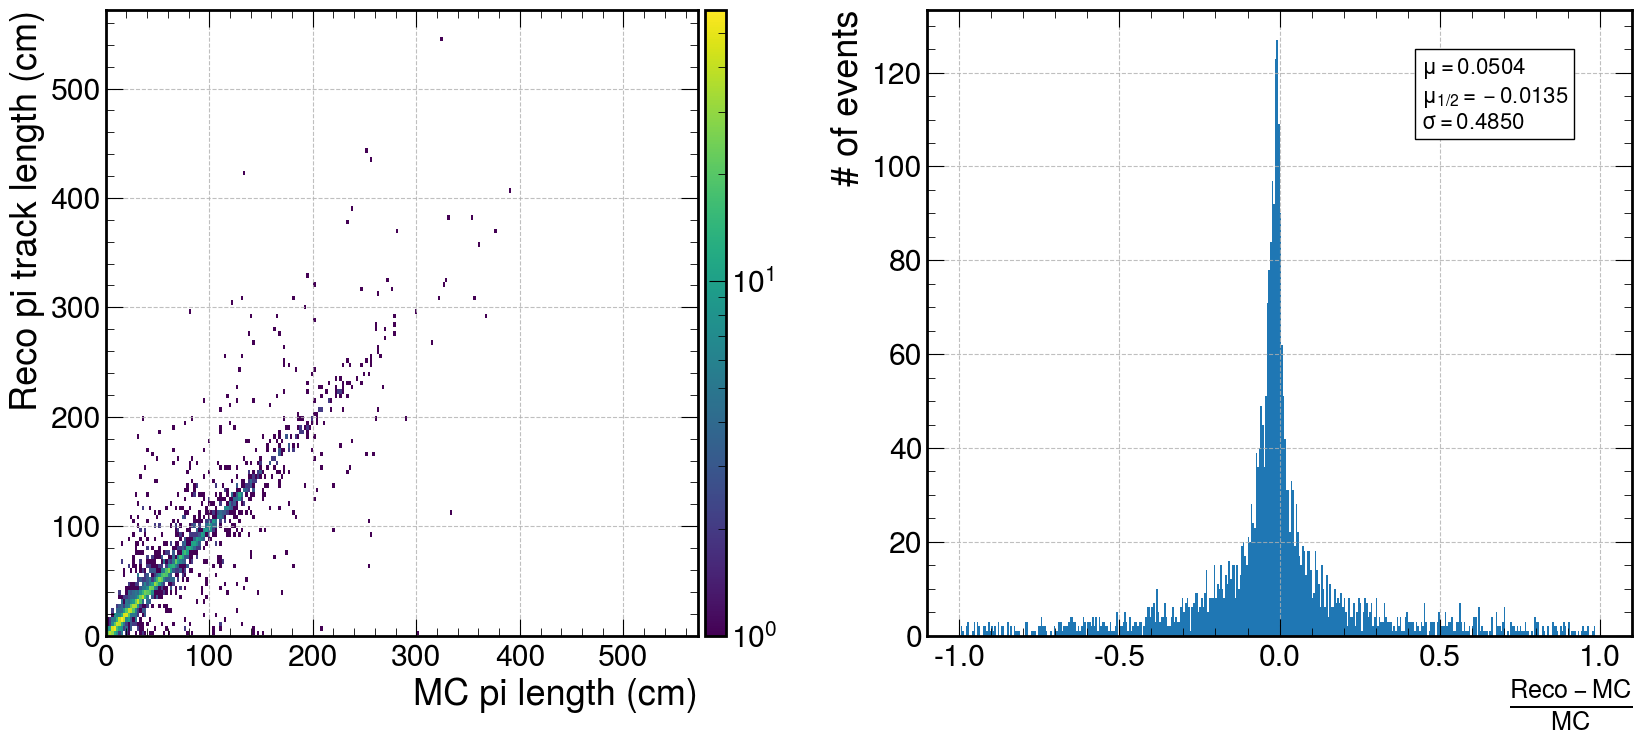

In [386]:
process_data(211)
plot_track_range(211,100,0.7,1)

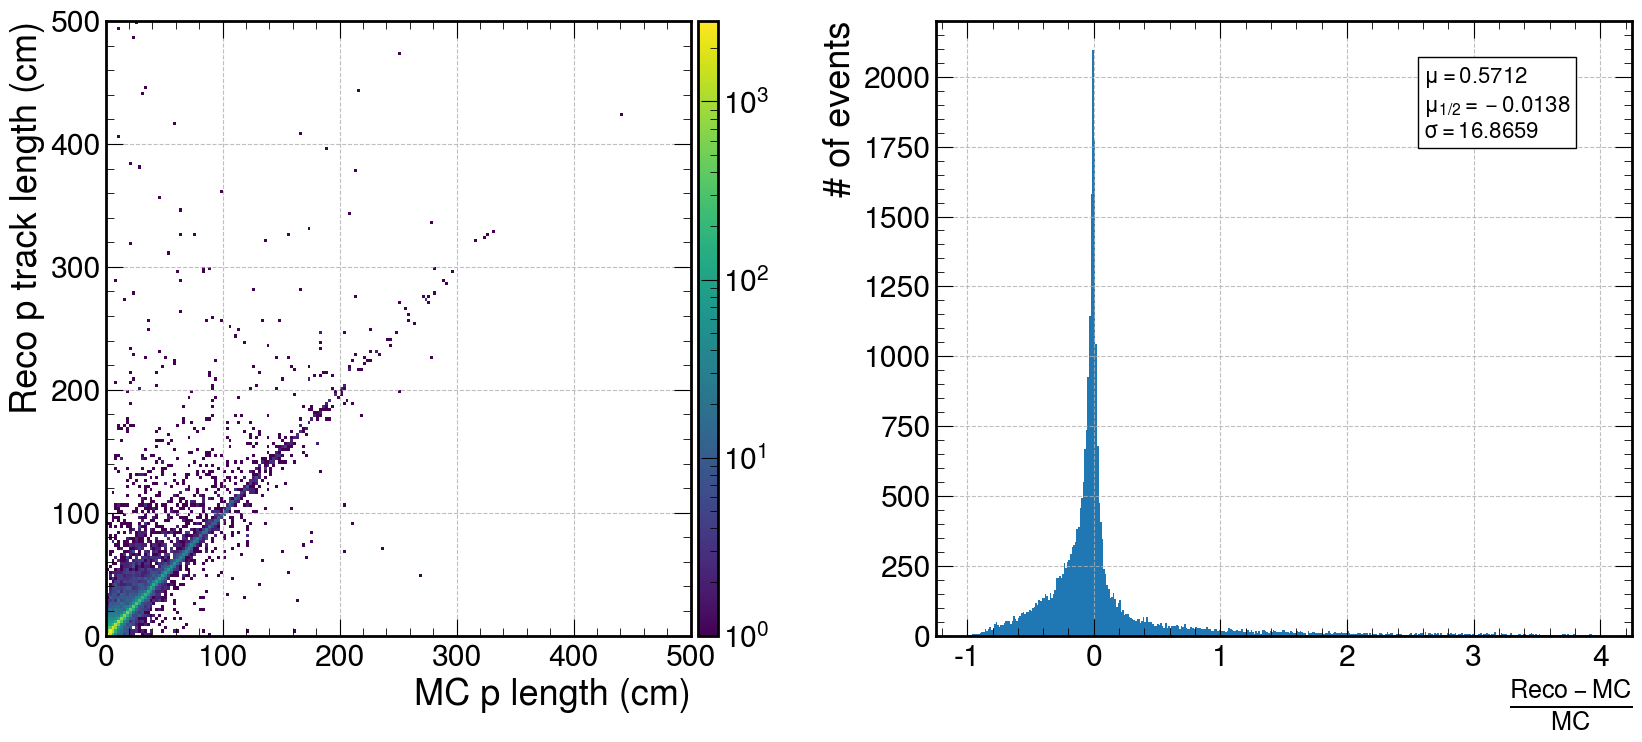

In [389]:
process_data(2212)
plot_track_range(2212,tick_distance=100,bins2d=[200,200],range=[[0,500],[0,500]],max_res=4)

In [4]:
data = data_original
data_no_track = data[data["ntracks_pandoraTrack"] == 0]
data_no_track_no_shower = data_no_track[data_no_track["nshowers_pandoraShower"] == 0]

data_no_track_no_shower_nu_cc = data_no_track_no_shower[abs(data_no_track_no_shower["nuPDG_truth"][:,0]) == 14]

data_no_track_no_shower_nu_cc = data_no_track_no_shower_nu_cc[data_no_track_no_shower_nu_cc["ccnc_truth"][:,0]== 0]

mask_primary = data_no_track_no_shower_nu_cc["Mother_geant"] == 0
mask_mu = data_no_track_no_shower_nu_cc["pdg_geant"][mask_primary] == 13
nu_energy_not_reco = ak.flatten(data_no_track_no_shower_nu_cc["Eng_geant"][mask_mu])
plt.hist(nu_energy_not_reco, bins=200);


NameError: name 'data_original' is not defined